### Работу выполнила Власкина Дарья

In [1]:
%matplotlib inline

In [2]:
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn . pipeline import Pipeline
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display, clear_output
import math
from tqdm.auto import tqdm

Введем некоторые константы

In [3]:
NUM_LABELS = 10
SEED = 42
INPUT_DIR = "./dz_data/splitted" # путь до данных для обучения
OUTPUT_FNAME = "submission.csv" # здесь должно быть записано имя выходного файла с ответами модели
CLS_LIST = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Загрузим данные для обучения и теста

In [4]:
X_train = np.load(f"{INPUT_DIR}/x_train.npy")
y_train = np.load(f"{INPUT_DIR}/y_train.npy")
X_test = np.load(f"{INPUT_DIR}/x_test.npy")

Посмотрим, как выглядят наши данные

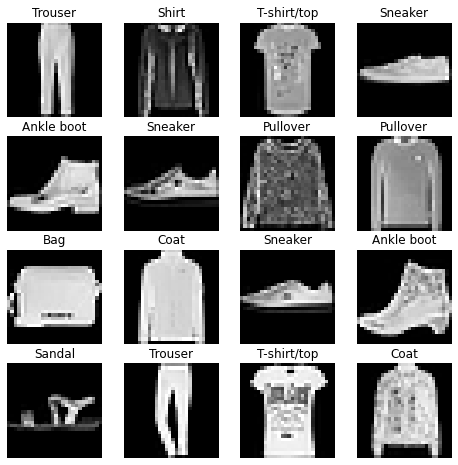

In [5]:
plt.figure(figsize=(8,8))
np.random.seed(SEED)
num_rc = 4
for i in range(16):
    idx = np.random.randint(X_train.shape[0])
    ax = plt.subplot(num_rc, num_rc, i + 1)
    ax.set_title(CLS_LIST[y_train[idx]])
    ax.set_axis_off()
    plt.imshow(X_train[idx].reshape(28,28), cmap='gray', vmin = 0, vmax = 255)

Разделим обучение на train и test

In [6]:
def train_test_split(X_train, y_train, valid_share = 0.3):
    valid_size = int(X_train.shape[0] * valid_share)
    indexes = list(range(X_train.shape[0])) 
    np.random.shuffle(indexes) 
    return X_train[indexes[valid_size:]], X_train[indexes[:valid_size]], y_train[indexes[valid_size:]], y_train[indexes[:valid_size]]

In [7]:
# Необходимо дописать пайплайн разделения данных 
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

Определим классы наших слоев

In [8]:
class Dense:
    def __init__(self, in_size, out_size):
        np.random.seed(1)
        self.W = np.random.normal(scale=0.1, size=(out_size, in_size))
        self.b = np.random.normal(scale=0.1, size=out_size)
        
    def forward(self, x):
        self.x = x
        return np.dot(self.W, x.T).T + self.b.T
    
    def backward(self, dz, lr=0.01, lambd=0.1):  
        self.dW = np.zeros(self.W.shape) 
        for i in range(len(dz)):
            self.dW += np.outer(dz[i], self.x[i]) 
        self.dW = self.dW / len(dz) + lambd * self.W / 10
        self.db = 1 / len(dz) * np.sum(dz, axis=0) 
        self.dx = np.matmul(dz, self.W) 
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db 
        return self.dx 

In [9]:
class ReLU: 
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.01):
        dz[self.x < 0] = 0
        return dz

In [10]:
class Softmax:
    def forward(self, x):
        self.x = x
        x -= np.amax(x, axis=1).reshape(-1, 1)
        exps = np.exp(x)
        return exps / np.sum(exps, axis=1).reshape(-1, 1)
    
    def backward(self, dz, lr=0.01): 
        sm = self.forward(self.x) 
        self.derivatives = []
        delta = np.eye(sm.shape[1], sm.shape[1])
        for i in range(sm.shape[0]):
            self.derivatives.append(np.dot(dz[i], sm[i] * (delta - sm[i]).T))
        return self.derivatives

In [11]:
class CrossEntropy: 
    def forward(self, y_true, y_prob):
        self.y_true = y_true
        self.y_prob = y_prob
        return -np.sum(y_true * np.log(y_prob), axis=1) 
    
    def backward(self, dz, lr=0.01):
        return dz * -1. * self.y_true / (self.y_prob)

Соберем сеть для классификации изображений

In [12]:
class FashionMnistNet:
    def __init__(self):
        self.d1 = Dense(784, 50) 
        self.a = ReLU()
        self.d2 = Dense(50, 10) 
        self.sm = Softmax()
        
    def forward(self, x):
        x = self.d1.forward(x)
        x = self.a.forward(x)
        x = self.d2.forward(x)
        x = self.sm.forward(x)
        return x
    
    def backward(self, dz, lr=0.01, lambd=0.1):
        dz = self.sm.backward(dz, lr)
        dz = self.d2.backward(dz, lr, lambd)
        dz = self.a.backward(dz, lr)
        dz = self.d1.backward(dz, lr, lambd)
        return dz

Предобработаем наши данные

In [13]:
def scale_up(data):
    data = data.astype('float')
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    return (data - data_mean) / (data_std + 0.0001)

In [14]:
# тут необходимо дописать базовую предобработку датасета
Xt_train_mod = scale_up(X_train)
Xt_test_mod = scale_up(X_valid)
X_test_mod = scale_up(X_test)

In [15]:
# заэнкодим наши ответы
t = OneHotEncoder(sparse=False)
yt_train_oh = t.fit_transform(y_train.reshape(-1, 1))
yt_test_oh = t.fit_transform(y_valid.reshape(-1, 1))

In [16]:
net = FashionMnistNet()
loss = CrossEntropy()

In [17]:
def change_learning_rate(lr0, epoch, s=10): 
    return lr0 * 0.1**(epoch/s) 

In [18]:
np.random.seed(SEED)
NUM_EPOCH = 100500
lr0 = 0.2 # начальная скорость обучения  
L_train_acc = [] # массив для хранения лоссов на обучении за эпоху
L_test_acc = [] # массив для хранения лоссов на отложенном сете
Acc_test_acc = [] # массив для хранения точности на отложенном сете за эпоху
batch_size = 64 
lambd = 0.1 # параметр регуляризации
Acc_to_stop = 0.88
lr = lr0 

for epoch in tqdm(range(NUM_EPOCH)):
    # ЧАСТЬ 1:
    # проводим эпоху обучения, сохраняем средний лосс по всем примерам за эпоху
    # в переменной L_train_acc
    
    Lt_acc = 0. 
    indexes = list(range(Xt_train_mod.shape[0])) 
    np.random.shuffle(indexes)
    iters_count = math.ceil(Xt_train_mod.shape[0] / batch_size)
    
    for i in range(iters_count):
        bound = min(Xt_train_mod.shape[0], (i + 1) * batch_size)
        x = Xt_train_mod[indexes[i * batch_size : bound]]
        y = yt_train_oh[indexes[i * batch_size : bound]]
        y_prob = net.forward(x) 
        L = loss.forward(y, y_prob)
        Lt_acc += 1 / y.shape[0] * np.sum(L) + lambd * (np.sum(net.d1.W ** 2) + np.sum(net.d2.W ** 2)) / 20 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr, lambd)               
        
    L_train_acc.append(Lt_acc / iters_count) 
    
    # ЧАСТЬ 2:
    # Оцениваем сеть после одной эпохи на отложенной выборке
    # Сохраняем средний лосс в переменной L_test_acc
    # Сохраняем среднее значение accuracy в Acc_test_acc

    L_acc = 0.
    acc = 0.
    
    y_prob = net.forward(Xt_test_mod)
    L = loss.forward(yt_test_oh, y_prob)
    L_acc = 1 / Xt_test_mod.shape[0] * np.sum(L)
    arg_y = np.argmax(yt_test_oh, axis=1)
    arg_t = np.argmax(y_prob, axis=1)
    acc = arg_t[arg_y == arg_t].shape[0]  /  Xt_test_mod.shape[0] 
            
    L_test_acc.append(L_acc)
    Acc_test_acc.append(acc)
    
    lr = change_learning_rate(lr0, epoch, 30)
    
    # Выводим 2 графика : 
    # 1) Лоссы на трейне и отложенном сете по эпохам
    # 2) Точность(accuracy) по эпохам на отложенном сете
    
    # заканичваем обучение, как достигли желаемого качества
    
    if Acc_test_acc[-1] >= Acc_to_stop:
        break      

  0%|          | 0/100500 [00:00<?, ?it/s]

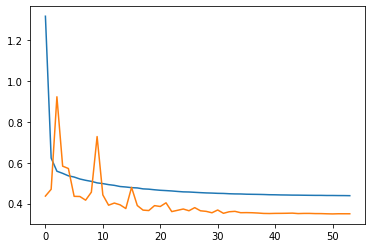

In [19]:
plt.plot([i for i, v in enumerate(L_train_acc)], L_train_acc, [i for i, v in enumerate(L_test_acc)], L_test_acc)  
plt.show()

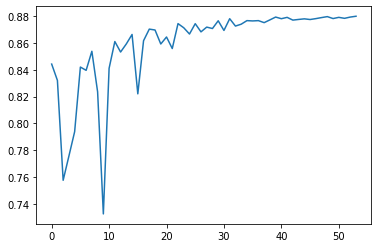

In [20]:
plt.plot(Acc_test_acc)
plt.show()

In [21]:
# формируем сабмишшен
n_out = net.forward(X_test_mod)

with open(OUTPUT_FNAME, 'w') as fout: 
    fout.write("Id,Category\n")
    for i in range(n_out.shape[0]):
        fout.write(f"{i},{np.argmax(n_out[i], axis=0)}\n")